<a href="https://colab.research.google.com/github/debojit11/Deep_Learning_Pytorch/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Convert MNIST Image Files into a Tensor of 4-Dimensions (# of images, Height, Width, Color Channels)
transform = transforms.ToTensor()

In [3]:
# Train Data
train_data = datasets.MNIST(root='/cnn', train = True, download=True, transform=transform)

In [4]:
# Test Data
test_data = datasets.MNIST(root='/cnn', train = False, download=True, transform=transform)

In [5]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn
    Split: Test
    StandardTransform
Transform: ToTensor()

In [7]:
# Create a small batch size for images...let's say 10
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [8]:
# Define Our CNN Model
# Describe convolutional layer and what it's doing (2 convolutional layers)
# This is just an example in the next video we'll build out the actual model
conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1)
conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1)

In [9]:
# Grab 1 MNIST record/image
for i, (X_train, y_train) in enumerate(train_data):
    break

In [10]:
X_train.shape

torch.Size([1, 28, 28])

In [11]:
x = X_train.view(1, 1, 28, 28)

In [12]:
# Perform our first convolution
x = F.relu(conv1(x))

In [13]:
x.shape
# 1 single image, 6 is the filters we asked for, 26x26(not 28 by 28 cause borders of the images doesn't have any value, thats why it got dropped)

torch.Size([1, 6, 26, 26])

In [14]:
# pass thru the pooling layer
x = F.max_pool2d(x, kernel_size=2, stride=2)

In [15]:
x.shape # 26 / 2 = 13

torch.Size([1, 6, 13, 13])

In [16]:
# Do our second convolutional layer
x = F.relu(conv2(x))

In [17]:
x.shape # Again, we didn't set padding so we lose 2 pixles around the outside of the image

torch.Size([1, 16, 11, 11])

In [18]:
# Pooling layer
x = F.max_pool2d(x,2,2)

In [19]:
x.shape # 11 / 2 = 5.5 but we have to round down, because you can't invent data to round up

torch.Size([1, 16, 5, 5])

In [20]:
((28-2) / 2 - 2) / 2

5.5

In [26]:
# Model class
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 6, 3, 1)
    self.conv2 = nn.Conv2d(6, 16, 3, 1)
    # Fully Connected Layer
    self.fc1 = nn.Linear(5*5*16, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)


  def forward(self, X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X, 2, 2) # 2x2 kernal and stride 2
    # Second Pass
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X, 2, 2)
    # Re-View to flatten it out
    X = X.view(-1, 16*5*5)  # negative one so that we can vary the batch size
     # Fully Connected Layers
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)
    return F.log_softmax(X, dim=1)

In [27]:
# Create an Instance of our Model
torch.manual_seed(41)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [28]:
# Loss Function Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Smaller the Learning Rate, longer its gonna take to train.

In [29]:
import time

start_time = time.time()

# Create Variables To Tracks Things
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# For Loop of Epochs
for i in range(epochs):
  train_corr = 0
  test_corr = 0

  # Train
  for b, (X_train, y_train) in enumerate(train_loader):
    b+=1 # start our batches at 1
    y_pred = model(X_train) # get predicted values from the training set. Not flattened 2D
    loss = criterion(y_pred, y_train) # compare the predicted

    predicted = torch.max(y_pred.data, 1)[1] # add up the number of correct predictions. Indexed off the first point
    batch_corr = (predicted == y_train).sum() # how many we got correct from this batch. True = 1, False=0, sum those up
    train_corr += batch_corr # keep track as we go along in training.

    # Update our parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    # Print out some results
    if b % 600 == 0:
      print(f'Epoch: {i} Batch: {b} Loss: {loss.item()}')

  train_losses.append(loss)
  train_correct.append(train_corr)

  # Test
  with torch.no_grad(): #No gradient so we don't update our weights and biases with test data
    for b, (X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1] # Adding up correct predictions
      test_corr += (predicted == y_test).sum() # T=1 F=0 and sum away

  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(test_corr)



current_time = time.time()
total_time = current_time - start_time
print(f'Training took: {total_time/60} minutes')

Epoch: 0 Batch: 600 Loss: 0.16236107051372528
Epoch: 0 Batch: 1200 Loss: 0.15510495007038116
Epoch: 0 Batch: 1800 Loss: 0.4651116728782654
Epoch: 0 Batch: 2400 Loss: 0.17726822197437286
Epoch: 0 Batch: 3000 Loss: 0.007429888937622309
Epoch: 0 Batch: 3600 Loss: 0.37731707096099854
Epoch: 0 Batch: 4200 Loss: 0.004938055761158466
Epoch: 0 Batch: 4800 Loss: 0.0015040982980281115
Epoch: 0 Batch: 5400 Loss: 0.06845302879810333
Epoch: 0 Batch: 6000 Loss: 0.0004587689763866365
Epoch: 1 Batch: 600 Loss: 0.002925408538430929
Epoch: 1 Batch: 1200 Loss: 0.2792360186576843
Epoch: 1 Batch: 1800 Loss: 0.0018853390356525779
Epoch: 1 Batch: 2400 Loss: 0.0030733426101505756
Epoch: 1 Batch: 3000 Loss: 0.024190708994865417
Epoch: 1 Batch: 3600 Loss: 0.5062173008918762
Epoch: 1 Batch: 4200 Loss: 0.02014169655740261
Epoch: 1 Batch: 4800 Loss: 0.001421573688276112
Epoch: 1 Batch: 5400 Loss: 0.0006034405087120831
Epoch: 1 Batch: 6000 Loss: 0.1528162956237793
Epoch: 2 Batch: 600 Loss: 0.07298740744590759
Epoch

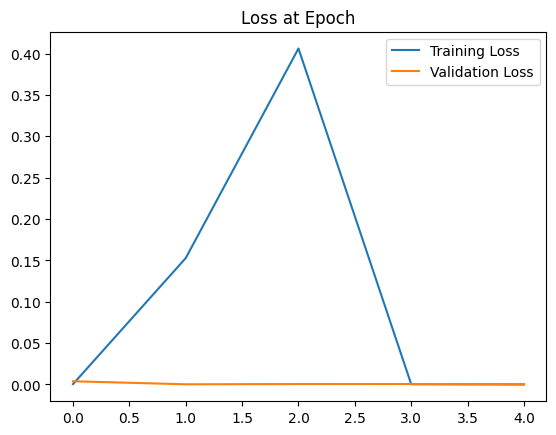

In [30]:
# Graph the loss at epoch
train_losses = [tl.item() for tl in train_losses]
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Validation Loss")
plt.title("Loss at Epoch")
plt.legend()

In [31]:
# graph the accuracy at the end of each epoch

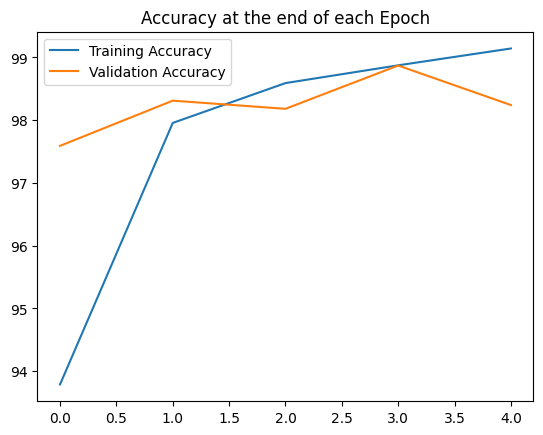

In [32]:
plt.plot([t/600 for t in train_correct], label="Training Accuracy")
plt.plot([t/100 for t in test_correct], label="Validation Accuracy")
plt.title("Accuracy at the end of each Epoch")
plt.legend()

In [33]:
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle=False)

In [34]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_everything:
    y_val = model(X_test)
    predicted = torch.max(y_val, 1)[1]
    correct += (predicted == y_test).sum()

In [36]:
# Did for correct
correct.item()/len(test_data)*100

98.24000000000001

In [38]:
# Grab an image
test_data[1978] # Tensor with an image in it...at end, it shows the label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [40]:
# Grab just the data
test_data[1978][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [41]:
# Reshape it
test_data[1978][0].reshape(28,28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

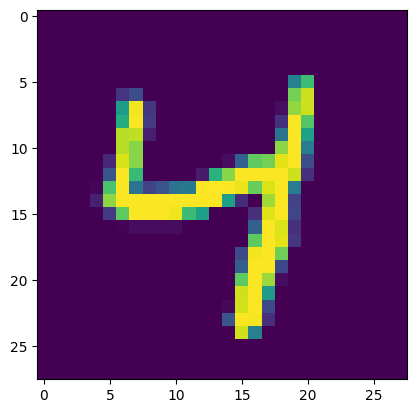

In [43]:
# Show the image
plt.imshow(test_data[1978][0].reshape(28,28))

In [44]:
# Pass the image thru our model
model.eval()
with torch.no_grad():
  new_pred = model(test_data[1978][0].view(1,1,28,28))  # batch size of 1, 1 color channel, 28x28 image

In [45]:
new_pred

tensor([[-2.3300e+01, -1.4064e+01, -2.1915e+01, -2.4329e+01, -3.8147e-06,
         -1.4821e+01, -1.2952e+01, -2.2707e+01, -1.9256e+01, -1.5313e+01]])

In [46]:
new_pred.argmax()

tensor(4)